In [32]:
import torch
import io
from PIL import Image
from transformers import YolosFeatureExtractor, YolosForObjectDetection, TrOCRProcessor, VisionEncoderDecoderModel
import requests
import matplotlib.pyplot as plt
import warnings
from osx_ocr import osx_ocr

### Run OCR from OS X's built in OCR library

## Detecting license plates

In [2]:
def fig2img(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    pil_img = Image.open(buf)
    if pil_img.mode == 'RGBA':
        pil_img = pil_img.convert('RGB')
    basewidth = 750
    wpercent = (basewidth/float(pil_img.size[0]))
    hsize = int((float(pil_img.size[1])*float(wpercent)))
    img = pil_img.resize((basewidth,hsize), Image.Resampling.LANCZOS) 
    img.convert('RGBA')
    return img

In [3]:
COLORS = [
    [0.000, 0.447, 0.741],
    [0.850, 0.325, 0.098],
    [0.929, 0.694, 0.125],
    [0.494, 0.184, 0.556],
    [0.466, 0.674, 0.188],
    [0.301, 0.745, 0.933]
]

In [4]:
image = None

In [5]:
if not image:
    image = Image.open("example_1.jpg")

In [6]:
if not image:
    url = 'https://drive.google.com/uc?id=1p9wJIqRz3W50e2f_A0D8ftla8hoXz4T5'
    image = Image.open(requests.get(url, stream=True).raw)

In [10]:
ocr_processor = TrOCRProcessor.from_pretrained('microsoft/trocr-large-printed')
ocr_model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-large-printed')

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-large-printed and are newly initialized: ['encoder.pooler.dense.weight', 'encoder.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
# Reference usage: https://huggingface.co/spaces/nickmuchi/license-plate-detection-with-YOLOS/blob/main/app.py
feature_extractor = YolosFeatureExtractor.from_pretrained('nickmuchi/yolos-small-rego-plates-detection')
model = YolosForObjectDetection.from_pretrained('nickmuchi/yolos-small-rego-plates-detection')
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

/Users/vp/anaconda3/envs/license-plates/lib/python3.11/site-packages/transformers/models/yolos/feature_extraction_yolos.py:28: FutureWarning: The class YolosFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use YolosImageProcessor instead.
  warnings.warn(
The `max_size` parameter is deprecated and will be removed in v4.26. Please specify in `size['longest_edge'] instead`.


In [16]:
def decode_image(img):
    pixel_values = ocr_processor(images=img, return_tensors="pt").pixel_values
    generated_ids = ocr_model.generate(pixel_values)
    generated_text = ocr_processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
    return generated_text

text: TOTAL
text: T
<PIL.Image.Image image mode=RGB size=250x117 at 0x135554810>


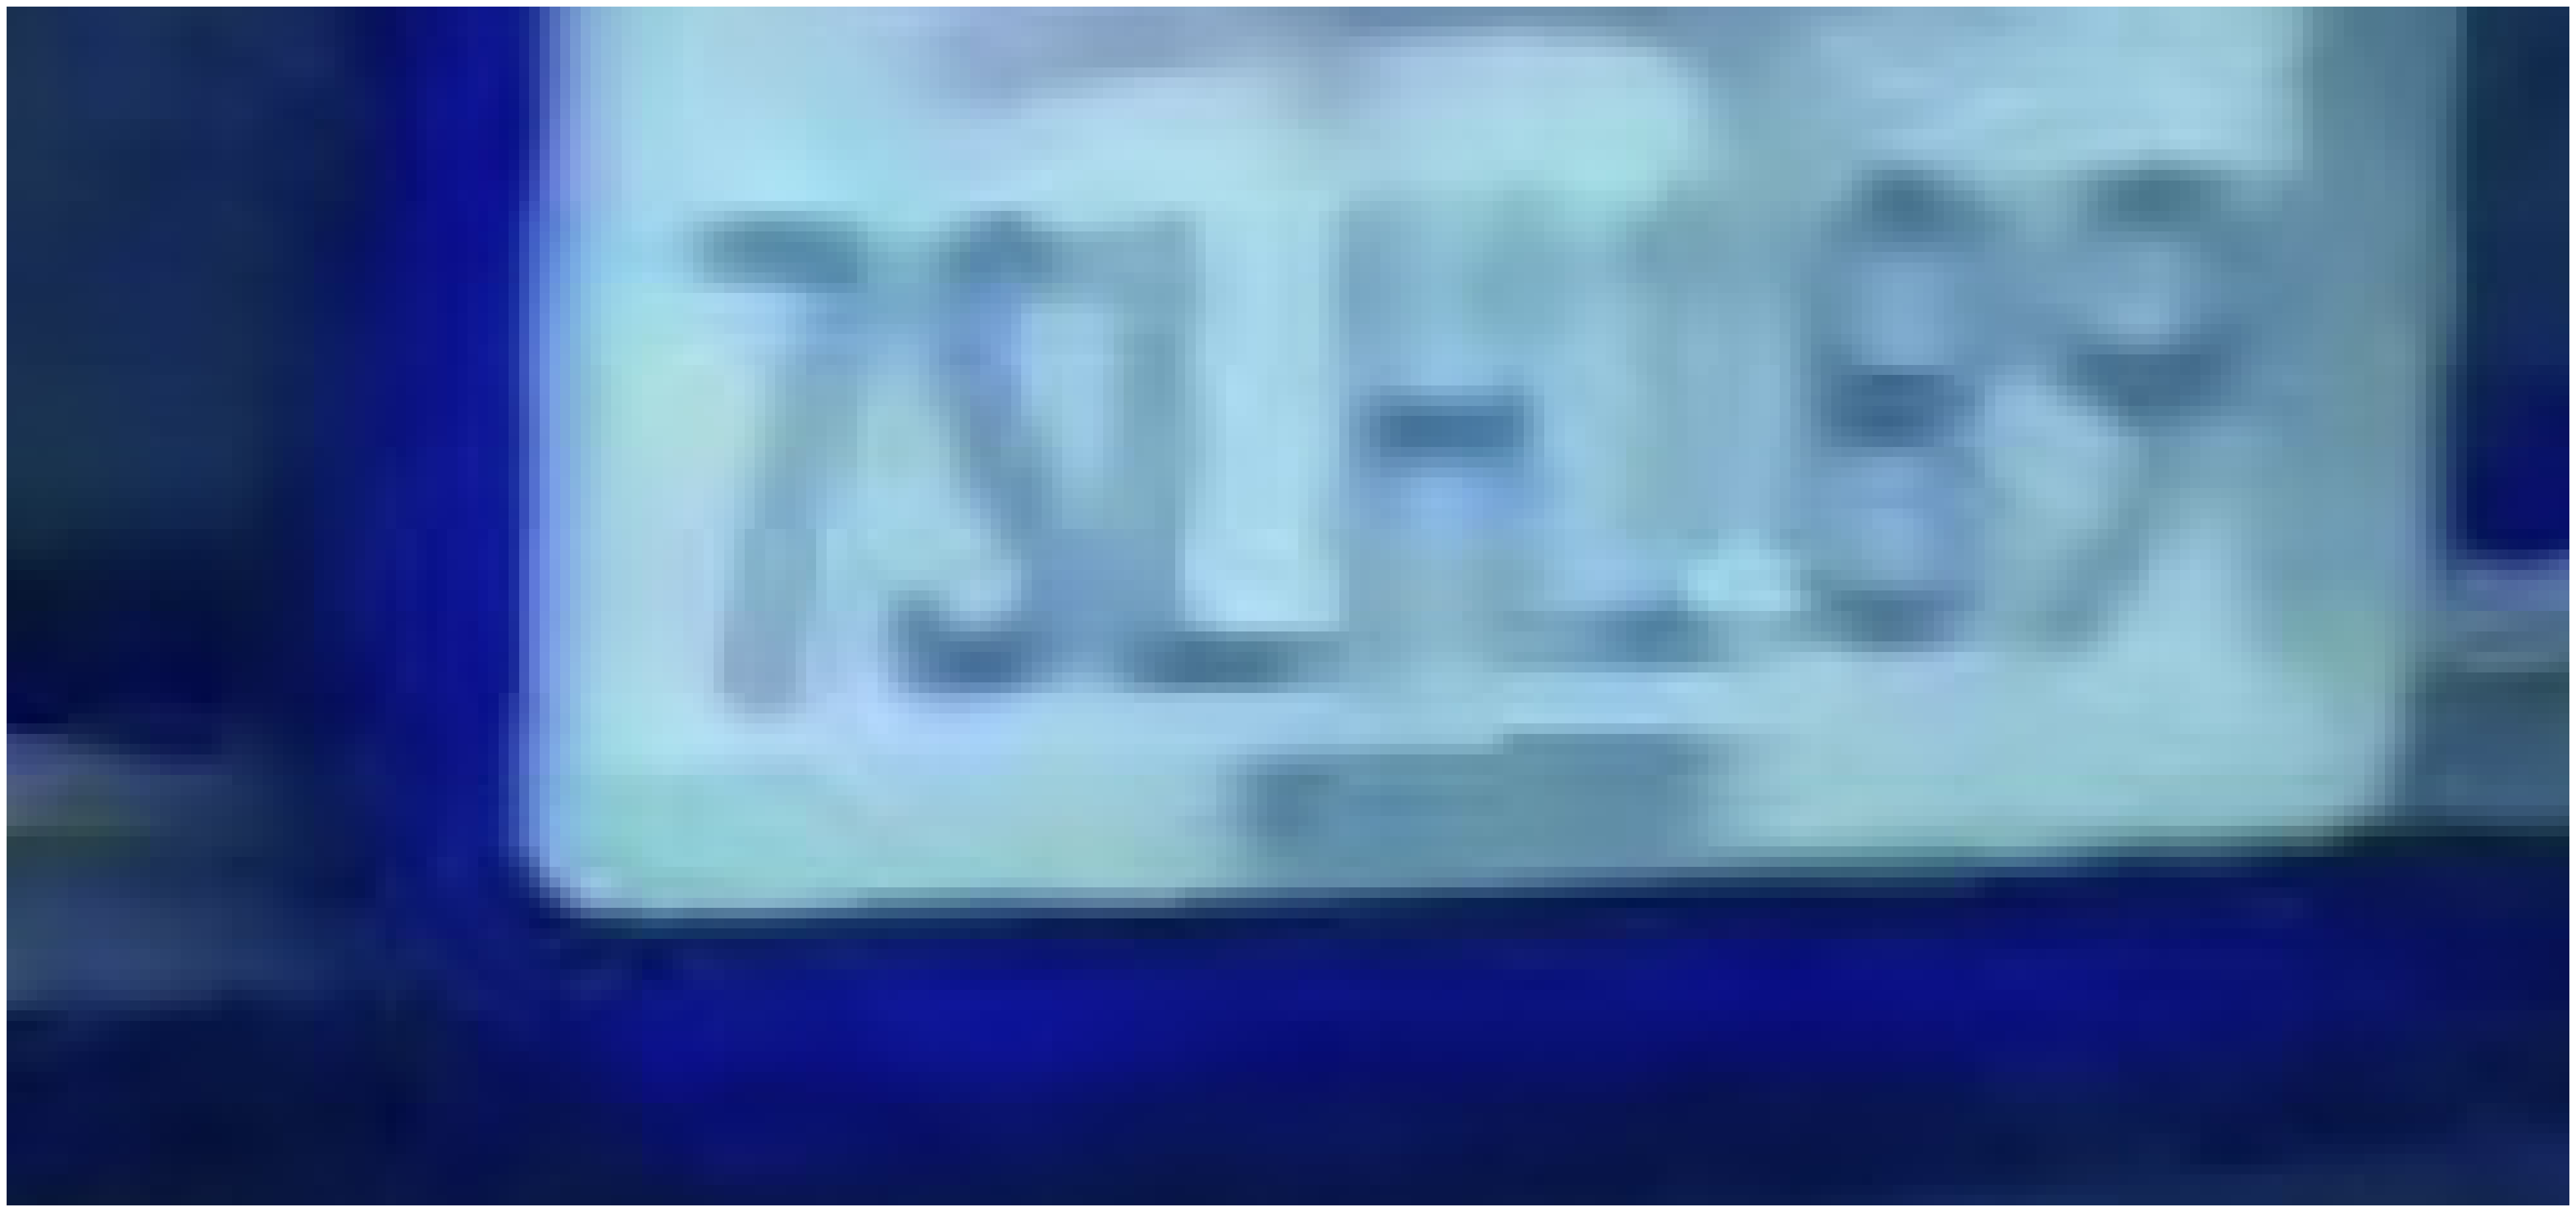

In [22]:
img_size = torch.tensor([tuple(reversed(image.size))])
processed_outputs = feature_extractor.post_process(outputs, img_size)
def visualize_prediction(img, output_dict, threshold=0.5, id2label=None):
    keep = output_dict["scores"] > threshold
    boxes = output_dict["boxes"][keep].tolist()
    scores = output_dict["scores"][keep].tolist()
    labels = output_dict["labels"][keep].tolist()
    
    if id2label is not None:
        labels = [id2label[x] for x in labels]
        
    plates = []
        
    for score, box, label in zip(scores, boxes, labels):
        plate = img.copy()
        plate = plate.crop(box)
        plates.append(plate)
        txt = decode_image(plate)
        print("text: "+txt)

    plt.figure(figsize=(50, 50))
    
    if len(plates) > 0:
        plt.imshow(plates[0])
        print(plates[0])
        if plates[0].mode == 'RGBA':
            plates[0] = plates[0].convert('RGB')
        plates[0].save("license.jpg")
        
    # ax = plt.gca()
    # colors = COLORS * 100
    # for score, (xmin, ymin, xmax, ymax), label, color in zip(scores, boxes, labels, colors):
    #    if label == 'license-plates':
    #        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin, fill=False, color=color, linewidth=10))
    #        ax.text(xmin, ymin, f"{label}: {score:0.2f}", fontsize=60, bbox=dict(facecolor="yellow", alpha=0.8))
    plt.axis("off")
    fig2img(plt.gcf())
visualize_prediction(image, processed_outputs[0], 0.5, model.config.id2label)